In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
# from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /cim/<username>/ecse626proj/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT

/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [2]:
set_determinism(42)

## Checking data and downsizing

In [3]:
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from common.utils import plot_brain_3_views

In [5]:
data_dir = "/cim/ehoney/ecse626proj/preprocessed_data"

(128, 128, 128)


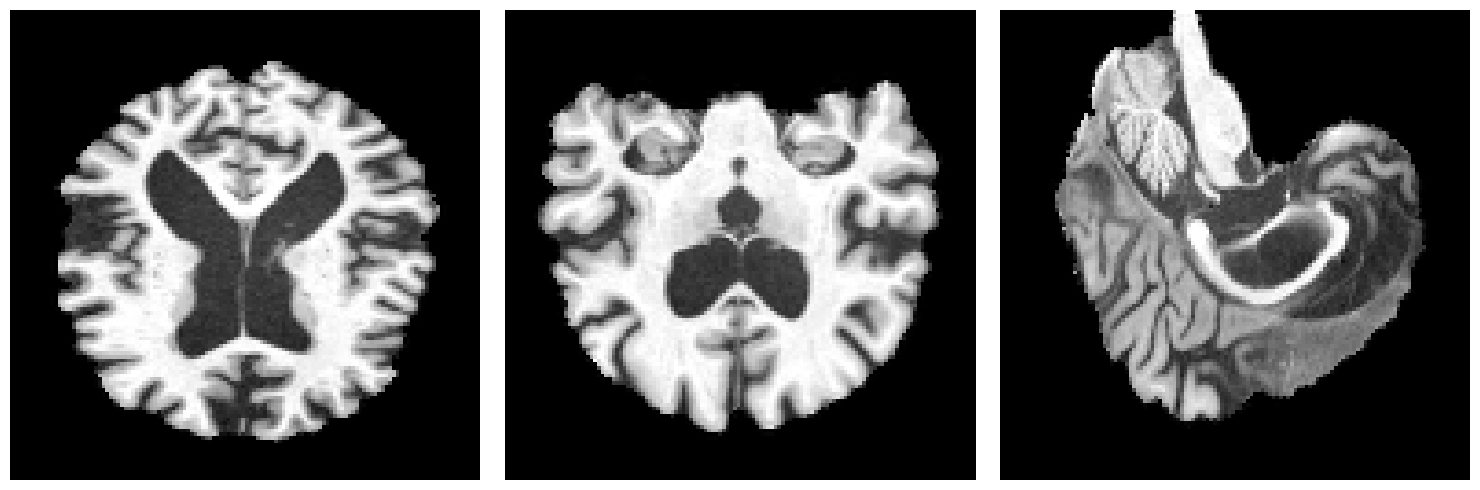

(64, 64, 64)


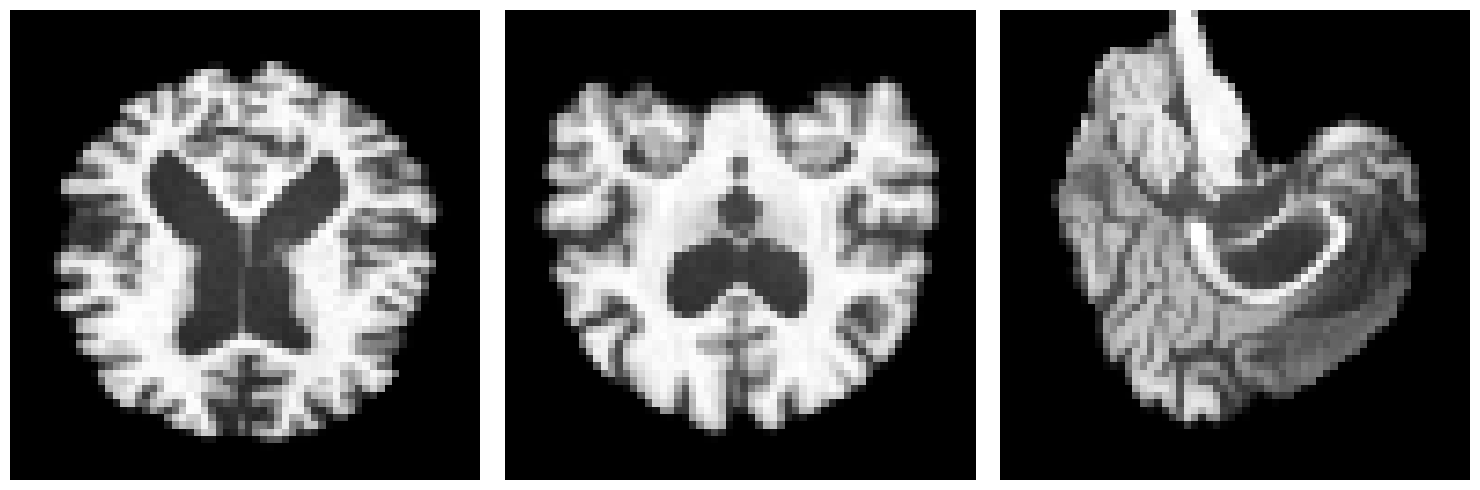

In [6]:
for i, subject in enumerate(os.listdir(data_dir)):
    subject_path = os.path.join(data_dir, subject)
    brain_data = np.load(subject_path)
    print(brain_data.shape)
    plot_brain_3_views(brain_data)

    brain_data = resize(brain_data, (64, 64, 64), order=3, mode='constant', anti_aliasing=True)
    print(brain_data.shape)
    plot_brain_3_views(brain_data)
    
    
    break

Now downsized data saved in `"/cim/ehoney/ecse626proj/preprocessed_data_64"`

## Trying MONAI unconditional model

Check which slices to use

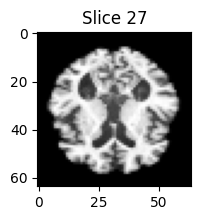

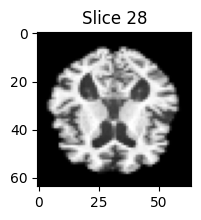

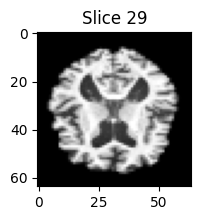

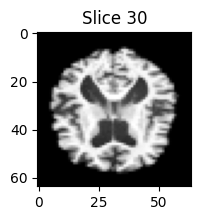

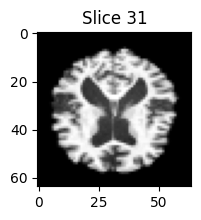

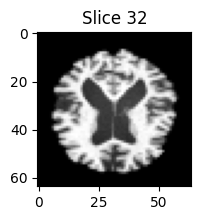

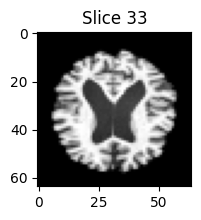

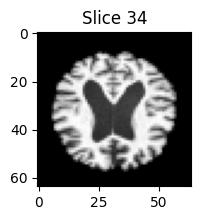

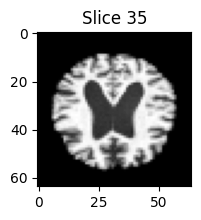

In [7]:
for i in range(27, 36):
    plt.figure(figsize=(2,2))
    plt.imshow(brain_data[i], cmap='gray')
    plt.title(f'Slice {i}')
    plt.show()

In [8]:
from common.dataset import ADNIDataset

In [9]:
batch_size = 4

data_dir = "/cim/ehoney/ecse626proj/preprocessed_data_64"
train_dataset = ADNIDataset(data_dir, sample_full_brain=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) # CHANGE to NUM_WORKERS=4

In [10]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

In [11]:
random_integer = torch.randint(27, 36, (4,))
random_integer

tensor([35, 34, 30, 29])

100%|██████████| 1000/1000 [00:16<00:00, 61.71it/s]


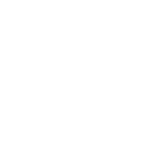

100%|██████████| 1000/1000 [00:15<00:00, 62.92it/s]


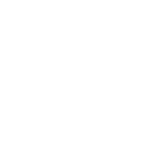

Epoch 11:  50%|████    | 109/216 [00:06<00:05, 18.04it/s, loss=0.0255]


KeyboardInterrupt: 

In [12]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 75
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            random_integers = torch.randint(27, 36, (4,))
            images = batch[torch.arange(batch_size), random_integers, :, :].to(device)
            images = images.unsqueeze(1).to(torch.float16)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True, device_type='cuda'):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            # model.eval()
            # val_epoch_loss = 0
            # for step, batch in enumerate(train_loader):
            #     random_integers = torch.randint(27, 36, (4,))
            #     images = batch[torch.arange(batch_size), random_integers, :, :].to(device)
            #     images = images.unsqueeze(1).to(torch.float16)
            #     with torch.no_grad():
            #         with autocast(enabled=True, device_type='cuda'):
            #             noise = torch.randn_like(images).to(device)
            #             timesteps = torch.randint(
            #                 0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            #             ).long()
            #             noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            #             val_loss = F.mse_loss(noise_pred.float(), noise.float())

            #     val_epoch_loss += val_loss.item()
            #     progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            # val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True, device_type='cuda'):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

100%|██████████| 1000/1000 [00:15<00:00, 63.46it/s]


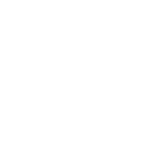

In [13]:
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True, device_type='cuda'):
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

plt.figure(figsize=(2, 2))
plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [21]:
torch.isnan(image).all()

tensor(True, device='cuda:0')